In [ ]:
import rosbag
import cv2
import numpy as np
from tqdm import tqdm
import bisect
from loguru import logger
import matplotlib.pyplot as plt
from converter import UTMtoLL, LLtoUTM

In [4]:
bag = rosbag.Bag('/mnt/UNENCRYPTED/ruichend/seq/seq3/seq_3.bag')
gps_fixed_msgs = []
for topic, msg, t in bag.read_messages(topics=['/mavros/global_position/raw/fix']):
    gps_fixed_msgs.append(msg)

In [5]:
_, gt_e, gt_n = LLtoUTM(23, 39.9411551, -75.1987216)

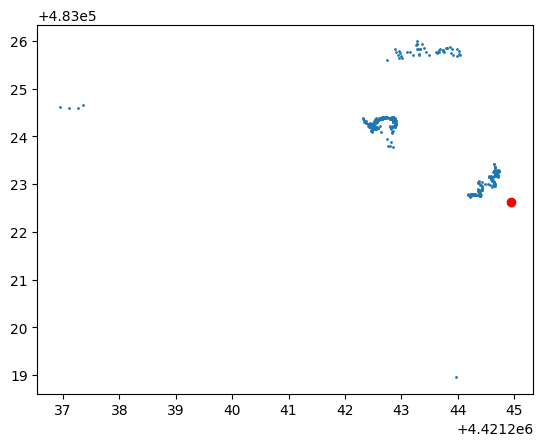

In [6]:
april = np.load('./logs/seq3_april5.npy')
plt.scatter(april[:, 0], april[:, 1], label='AprilTag', s=1)
plt.scatter(gt_n, gt_e, label='Ground Truth', color='red')

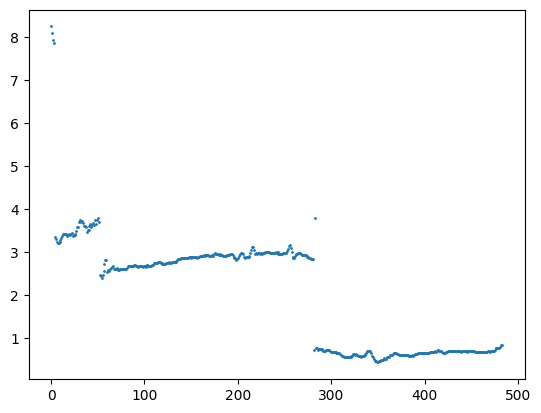

In [8]:
gt = np.array([gt_n, gt_e])
april_ne = april[:, :2]
err = np.linalg.norm(gt - april_ne, axis=1)
plt.scatter(np.linspace(0, len(err), len(err)), err, s = 1, label='Error')

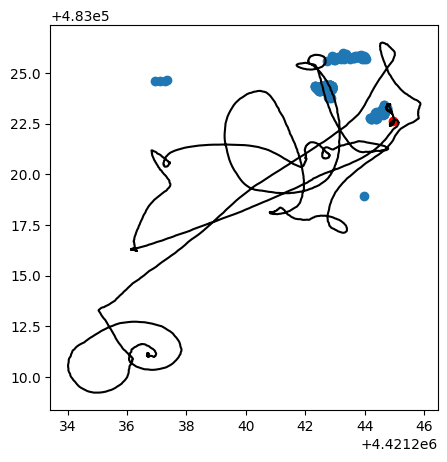

In [11]:
xyz = []

for msg in gps_fixed_msgs:
    lon, lat = msg.longitude, msg.latitude
    _, easting, northing = LLtoUTM(23, lat, lon)
    # xyz.append(
    #     [msg.longitude, msg.latitude, msg.altitude]
    # )
    xyz.append(
        [easting, northing, msg.altitude]
    )
    

xyz = np.array(xyz)



plt.figure(figsize=(5, 5))
plt.plot(xyz[:, 1], xyz[:, 0], c='k')
plt.scatter(april[:, 0], april[:, 1])
# plt.xlim(xyz[:, 0].min(), xyz[:, 0].max())
# plt.ylim(xyz[:, 1].min(), xyz[:, 1].max())
# plt.xlim(-75.1995, -75.1980)
# plt.ylim(39.9408, 39.94125)
plt.scatter(gt_n, gt_e, label='Ground Truth', color='red')

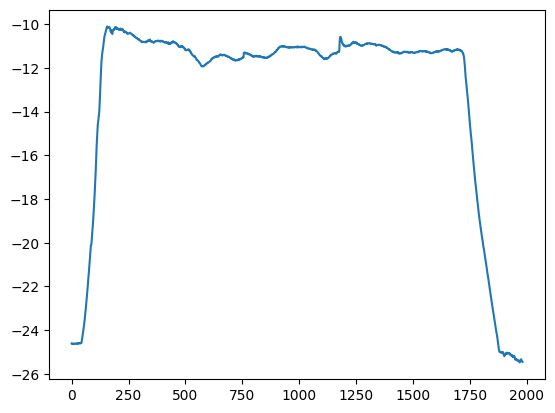

In [12]:
# plt.figure(plt.figure(figsize=(10, 10)))
plt.plot(xyz[:, 2])

In [23]:
import numpy as np
import matplotlib.pyplot as plt

In [24]:
ang = np.pi * 15 / 180

In [25]:
R = np.array([
    [np.cos(ang), -np.sin(ang)],
    [np.sin(ang), np.cos(ang)]
])

In [26]:
rotated = R @ np.array([-11, -26]).reshape(-1, 1)

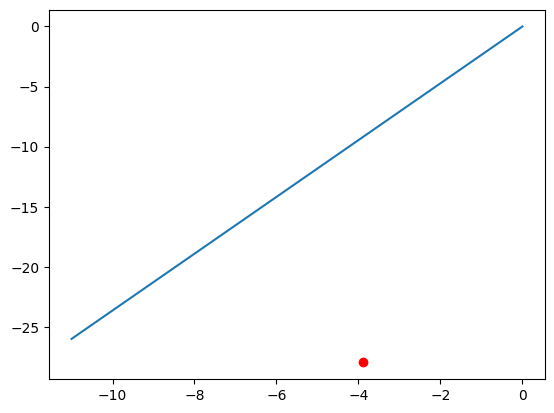

In [27]:
plt.plot([0, -11], [0, -26])
plt.scatter(rotated[0], rotated[1], c='r')

In [28]:
np.linalg.norm(rotated)

28.23118842698621

In [29]:
np.dot([-11, -26], rotated)/ np.linalg.norm(rotated)**2

array([0.96592583])

In [30]:
np.cos(ang)

0.9659258262890684

In [31]:
rotated.flatten()

array([ -3.89588892, -27.96108098])

In [32]:
rotated = rotated.flatten()

In [36]:
np.hstack((rotated, [1]))

array([ -3.89588892, -27.96108098,   1.        ])